In [ ]:
!pip install pytorch_forecasting lightning tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightning.pytorch as pl
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, GroupNormalizer
from pytorch_forecasting.metrics import RMSE
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
import seaborn as sns



In [ ]:
data=pd.read_csv("sales_grouped.csv")

In [ ]:
print("Data shape:", data.shape)
print("Data columns:", data.columns.tolist())

Data shape: (18048, 7)
Data columns: ['Product', 'Region', 'time_idx', 'Quantity', 'Total_Price', 'Unit_Price', 'Discount']


In [ ]:
pl.seed_everything(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

In [ ]:

train_cutoff_idx = 18  # time_idx < 18 for training (up to June 2024)

# Split the data
train_data = data[data['time_idx'] < train_cutoff_idx].copy()
val_data = data[data['time_idx'] >= train_cutoff_idx].copy()

# Display shapes
print(f"Train set shape: {train_data.shape}")
print(f"Validation set shape: {val_data.shape}")

Train set shape: (13536, 7)
Validation set shape: (4512, 7)


In [ ]:
#training dataset
from pytorch_forecasting.data.encoders import NaNLabelEncoder


training = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="Quantity",
    group_ids=["Product", "Region"],
    min_encoder_length=6,
    max_encoder_length=12,
    min_prediction_length=1,
    max_prediction_length=1,
    static_categoricals=["Product", "Region"],
    time_varying_known_reals=["time_idx", "Unit_Price", "Discount"],
    time_varying_unknown_reals=["Quantity", "Total_Price"],
    target_normalizer=GroupNormalizer(groups=["Product", "Region"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    categorical_encoders={
        "Region": NaNLabelEncoder(add_nan=True),
        "Product": NaNLabelEncoder(add_nan=True)
    },
    allow_missing_timesteps=True
)

In [ ]:
#validation dataset
validation = TimeSeriesDataSet.from_dataset(
    training,
    val_data,
    predict=True,
    stop_randomization=True,
    min_encoder_length=1,
    max_encoder_length=6
)


In [ ]:
#dataloaders
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

#dataset sizes
print(f"Training dataset size: {len(training)} samples")
print(f"Validation dataset size: {len(validation)} samples")

Training dataset size: 13536 samples
Validation dataset size: 752 samples


In [ ]:
#TFT model
from pytorch_forecasting.metrics import SMAPE
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0005,
    hidden_size=128,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    loss=SMAPE(),
    log_interval=10,
    reduce_on_plateau_patience=4
)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
#callbacks and logger
from tensorboard.backend.event_processing import event_accumulator

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=True,
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="tft_model")


In [ ]:
#trainer
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    devices="auto",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    logger=logger,
    enable_progress_bar=True
)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:

# Train the model
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

print("Model training completed.")

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | SMAPE                           | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 808    | train
3  | prescalers                         | ModuleDict                      | 288    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 17.9 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 34.9 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 23.1 K | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 0.244
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 0.244


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.044 >= min_delta = 0.0001. New best score: 0.200
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.044 >= min_delta = 0.0001. New best score: 0.200


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.017 >= min_delta = 0.0001. New best score: 0.183
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0001. New best score: 0.183


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.172
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.172


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.021 >= min_delta = 0.0001. New best score: 0.151
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0001. New best score: 0.151


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.144
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.144


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.135
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.135


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.133
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.133


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.128
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.128


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.120
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.120


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.119
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.119


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.115
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.115


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.108
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.108


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.106
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.106


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.099
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.099


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.097
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.097


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.096
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.096


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.095
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.095


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.092
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.092


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.091
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.091


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.089
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.089


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.088
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.088


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.087
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.087


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Model training completed.


*******************************************

Loss plot saved as 'training_validation_loss.png'


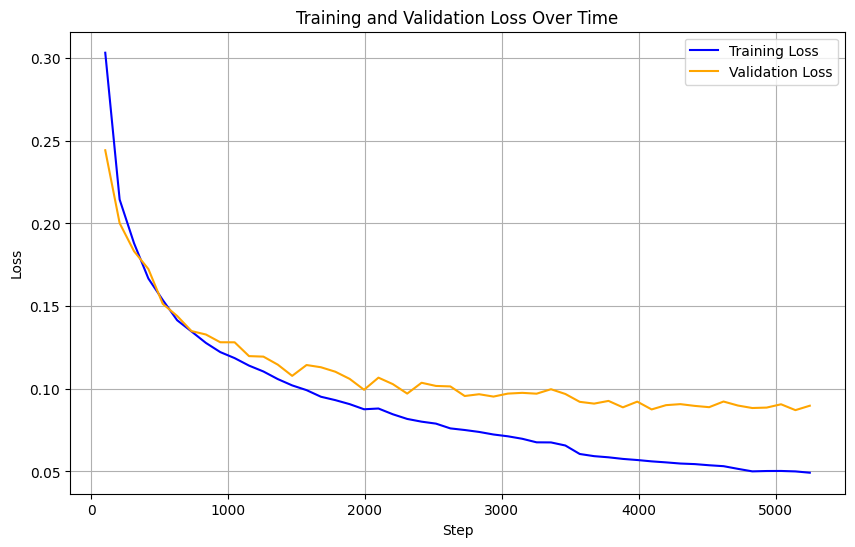

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import os
import glob


log_dir = "lightning_logs/tft_model"
latest_run = max(glob.glob(os.path.join(log_dir, "version_*")), key=os.path.getctime)
event_file = glob.glob(os.path.join(latest_run, "events.out.tfevents.*"))[0]


ea = event_accumulator.EventAccumulator(event_file)
ea.Reload()

#training and validation loss
train_loss = ea.Scalars("train_loss_epoch")
val_loss = ea.Scalars("val_loss")

train_steps = [s.step for s in train_loss]
train_values = [s.value for s in train_loss]
val_steps = [s.step for s in val_loss]
val_values = [s.value for s in val_loss]

#losses
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_values, label="Training Loss", color="blue")
plt.plot(val_steps, val_values, label="Validation Loss", color="orange")
plt.title("Training and Validation Loss Over Time")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("training_validation_loss.png")
print("Loss plot saved as 'training_validation_loss.png'")

In [ ]:
#predictions on the validation set
val_predictions = tft.predict(val_dataloader, mode="prediction")


preds = val_predictions.cpu().numpy().flatten()


actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).cpu().numpy().flatten()


#DataFrame for visualization
val_results = val_data[val_data["time_idx"] >= train_cutoff_idx].copy().reset_index(drop=True)
val_results = val_results.iloc[:len(preds)]  #
val_results["predicted_quantity"] = preds
val_results["actual_quantity"] = actuals

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Actual vs Predicted plot saved as 'actual_vs_predicted_by_region.png'


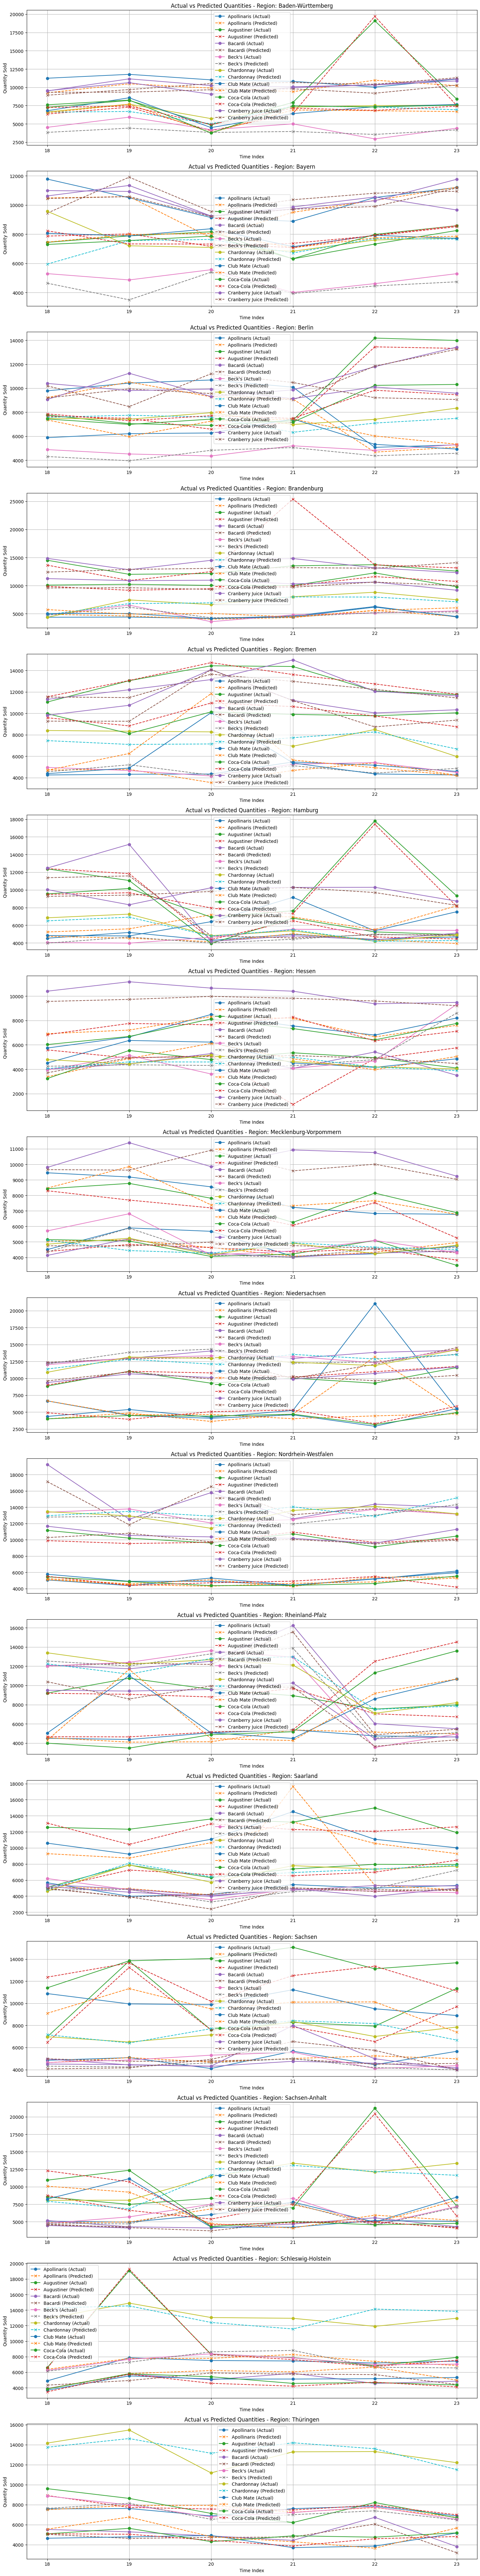

In [ ]:
# Group by region for visualization
unique_regions = val_results["Region"].unique()
n_regions = len(unique_regions)

#actual vs predicted for each region
plt.figure(figsize=(15, 5 * n_regions))
for i, region in enumerate(unique_regions, 1):
    region_data = val_results[val_results["Region"] == region]
    plt.subplot(n_regions, 1, i)
    for product in region_data["Product"].unique():
        product_data = region_data[region_data["Product"] == product]
        plt.plot(product_data["time_idx"], product_data["actual_quantity"],
                 label=f"{product} (Actual)", linestyle="-", marker="o")
        plt.plot(product_data["time_idx"], product_data["predicted_quantity"],
                 label=f"{product} (Predicted)", linestyle="--", marker="x")
    plt.title(f"Actual vs Predicted Quantities - Region: {region}")
    plt.xlabel("Time Index")
    plt.ylabel("Quantity Sold")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig("actual_vs_predicted_by_region.png")
print("Actual vs Predicted plot saved as 'actual_vs_predicted_by_region.png'")

Plot saved as 'best_product_actual_vs_predicted_by_region.png'


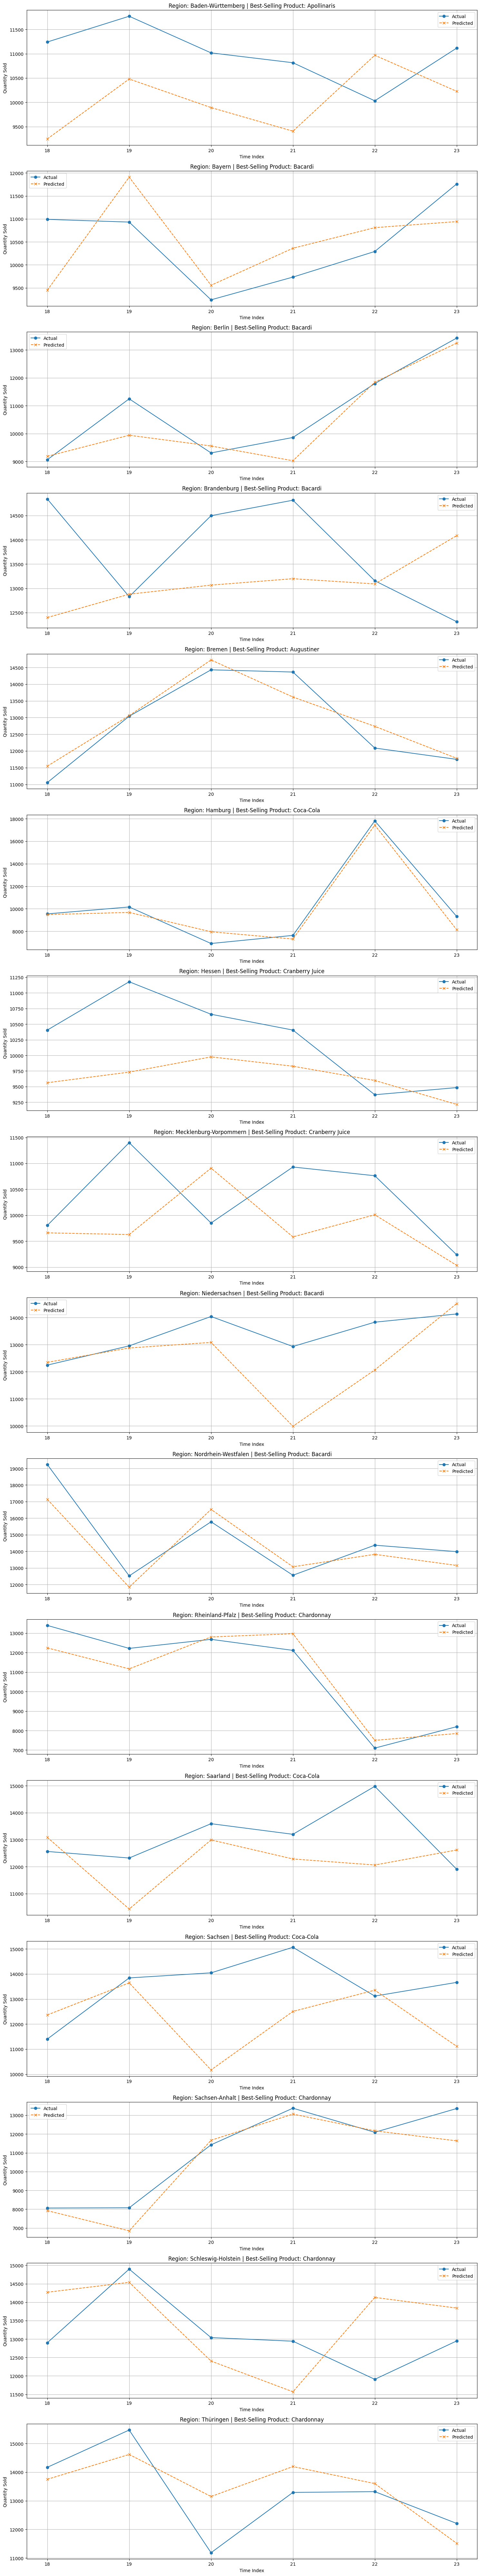

In [ ]:
# Group by region
unique_regions = val_results["Region"].unique()
n_regions = len(unique_regions)

# Get best-selling product in each region
best_products_by_region = (
    val_results.groupby(["Region", "Product"])["actual_quantity"].sum()
    .reset_index()
    .sort_values(["Region", "actual_quantity"], ascending=[True, False])
    .drop_duplicates(subset="Region")
)

#actual vs predicted for the best-selling product in each region
plt.figure(figsize=(15, 5 * n_regions))
for i, region in enumerate(unique_regions, 1):
    best_product = best_products_by_region[best_products_by_region["Region"] == region]["Product"].values[0]
    region_product_data = val_results[
        (val_results["Region"] == region) & (val_results["Product"] == best_product)
    ]

    plt.subplot(n_regions, 1, i)
    plt.plot(region_product_data["time_idx"], region_product_data["actual_quantity"],
             label="Actual", linestyle="-", marker="o")
    plt.plot(region_product_data["time_idx"], region_product_data["predicted_quantity"],
             label="Predicted", linestyle="--", marker="x")
    plt.title(f"Region: {region} | Best-Selling Product: {best_product}")
    plt.xlabel("Time Index")
    plt.ylabel("Quantity Sold")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig("best_product_actual_vs_predicted_by_region.png")
print("Plot saved as 'best_product_actual_vs_predicted_by_region.png'")


**********************

In [ ]:
# Predict for January 2025
max_time_idx = data["time_idx"].max()

#last 12 months for encoder
encoder_data = data[data["time_idx"] > max_time_idx - 12]

#decoder data (future 1 month)
decoder_data = encoder_data[encoder_data["time_idx"] == max_time_idx].copy()
decoder_data["time_idx"] = max_time_idx + 1  # Predict January 2025
decoder_data["Unit_Price"] = encoder_data["Unit_Price"].mean()
decoder_data["Discount"] = encoder_data["Discount"].mean()

#Merge encoder + decoder and reset index
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True).reset_index(drop=True)

#prediction dataset
prediction_dataset = TimeSeriesDataSet.from_dataset(
    training,
    new_prediction_data,
    predict=True,
    stop_randomization=True,
)

prediction_dataloader = prediction_dataset.to_dataloader(batch_size=64, train=False)

jan_predictions = tft.predict(prediction_dataloader, mode="prediction")

jan_predictions = jan_predictions.cpu().numpy().flatten()


decoder_data["predicted_quantity"] = jan_predictions

print("Predictions for January 2025 done.")

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predictions for January 2025 done.


In [ ]:
# Best-selling product overall
best_product = decoder_data.groupby("Product")["predicted_quantity"].sum().idxmax()
best_quantity = decoder_data.groupby("Product")["predicted_quantity"].sum().max()
print(f"🛒 Best selling product in January 2025: {best_product} ({best_quantity:.2f} units)")

# Best-selling product per region
predicted_sales_by_region = decoder_data.groupby(["Region", "Product"])["predicted_quantity"].sum().reset_index()
best_products_by_region = predicted_sales_by_region.sort_values(
    ["Region", "predicted_quantity"], ascending=[True, False]
).groupby("Region").first().reset_index()

print("\n🛒 Best-selling products per region in January 2025:")
display(best_products_by_region)

🛒 Best selling product in January 2025: Cranberry Juice (219137.16 units)

🛒 Best-selling products per region in January 2025:


Region              Product  predicted_quantity
0        Baden-Württemberg       Hohes C Orange        13550.794922
1                   Bayern         Tomato Juice        13569.109375
2                   Berlin           Fritz-Kola        20523.519531
3              Brandenburg  Passion Fruit Juice        13399.049805
4                   Bremen            Coca-Cola        19892.460938
5                  Hamburg      Cranberry Juice        25416.644531
6                   Hessen       Hohes C Orange        15934.138672
7   Mecklenburg-Vorpommern        Granini Apple        13298.933594
8            Niedersachsen       Hohes C Orange        16818.666016
9      Nordrhein-Westfalen                Fanta        15329.603516
10         Rheinland-Pfalz               Vittel        14916.459961
11                Saarland  Passion Fruit Juice        14422.402344
12                 Sachsen   Rauch Multivitamin        15093.373047
13          Sachsen-Anhalt   Rauch Multivitamin        14246.726562
14      Schleswig-Holstein   Rauch Multivitamin        14327.484375
15               Thüringen       Hohes C Orange        15750.109375

In [ ]:
# Save predictions to CSV
decoder_data.to_csv("predictions_janvier2025.csv", index=False)
print("save in predictions_janvier2025.csv")

save in predictions_janvier2025.csv
